In [83]:
import os
from pdf2image import convert_from_path
from PIL import Image
import cv2
import numpy as np
from tqdm import tqdm
import pytesseract
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import torchvision.models
import torch.optim as optim
import torch.nn as nn
from transformers import BertTokenizer, BertModel
import docx
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision
import torch.optim as optim
import seaborn as sns
from skimage.metrics import structural_similarity as ssim

In [2]:
PDF_DIR = "/home/aniketj/GSOC_TASK1/PDFs/"   # Directory containing PDFs
IMAGE_DIR = "/home/aniketj/GSOC_TASK1//IMAGES/"     # Output directory for images
os.makedirs(IMAGE_DIR, exist_ok=True)

In [3]:
def pdf_to_images(pdf_path, output_folder, dpi=200):
    """Convert PDF pages to images one by one, reducing image size issues."""
    images = convert_from_path(pdf_path, dpi=dpi, fmt="jpeg")  
    image_paths = []
    
    for i, img in enumerate(images):
        img = img.convert("RGB")  
        img_path = os.path.join(output_folder, f"{os.path.basename(pdf_path).replace('.pdf', '')}_page_{i+1}.jpg")
        img.save(img_path, "JPEG", quality=85)  
        image_paths.append(img_path)
    
    return image_paths

In [4]:
for pdf in os.listdir(PDF_DIR):
    if pdf.endswith(".pdf"):
        pdf_to_images(os.path.join(PDF_DIR, pdf), IMAGE_DIR, dpi=200)

print("PDF to Image Conversion Done")

/home/aniketj/anaconda3/envs/soc/lib/python3.10/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (94080000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


PDF to Image Conversion Done


In [5]:
PROCESSED_DIR = "/home/aniketj/GSOC_TASK1/PROCESSED_IMAGES/"
os.makedirs(PROCESSED_DIR, exist_ok=True)

In [ ]:
def preprocess_image(image_path, output_folder):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  
    img = cv2.GaussianBlur(img, (5, 5), 0)  
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) 

    processed_path = os.path.join(output_folder, os.path.basename(image_path))
    cv2.imwrite(processed_path, binary)  
    return processed_path

In [7]:
for img_file in tqdm(os.listdir(IMAGE_DIR), desc="Processing Images"):
    if img_file.endswith(".jpg"):
        preprocess_image(os.path.join(IMAGE_DIR, img_file), PROCESSED_DIR)

print("Image Preprocessing Done")

Processing Images: 100%|██████████| 57/57 [00:12<00:00,  4.42it/s]

Image Preprocessing Done


In [8]:
pytesseract.pytesseract.tesseract_cmd = r'/home/aniketj/anaconda3/envs/soc/bin/tesseract' 

In [9]:
TEXT_REGION_DIR = "/home/aniketj/GSOC_TASK1/TEXT_REGIONS/"
os.makedirs(TEXT_REGION_DIR, exist_ok=True)

In [10]:
def extract_text_regions(image_path, output_folder, visualize=False):

    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    d = pytesseract.image_to_data(gray, output_type=pytesseract.Output.DICT)
    
    for i in range(len(d["text"])):
        if int(d["conf"][i]) > 50:  
            (x, y, w, h) = (d["left"][i], d["top"][i], d["width"][i], d["height"][i])
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green box

    processed_path = os.path.join(output_folder, os.path.basename(image_path))
    cv2.imwrite(processed_path, img)  

    
    if visualize:
        cv2.imshow("Text Detection", img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    return processed_path

In [11]:
for img_file in tqdm(os.listdir(PROCESSED_DIR), desc="Extracting Text Regions"):
    if img_file.endswith(".jpg"):
        extract_text_regions(os.path.join(PROCESSED_DIR, img_file), TEXT_REGION_DIR)

print("Text Region Extraction Done")

Extracting Text Regions: 100%|██████████| 57/57 [04:10<00:00,  4.40s/it]

Text Region Extraction Done


In [14]:
JSON_OUTPUT = "/home/aniketj/GSOC_TASK1/BOUNDING_BOXES.json"  
bounding_boxes = {}

def extract_bounding_boxes(image_path):
    """Extract text bounding box coordinates using OCR."""
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    d = pytesseract.image_to_data(gray, output_type=pytesseract.Output.DICT)

    boxes = []  

    for i in range(len(d["text"])):
        if int(d["conf"][i]) > 50: 
            x, y, w, h = d["left"][i], d["top"][i], d["width"][i], d["height"][i]
            boxes.append({"x": x, "y": y, "width": w, "height": h})

    return boxes

In [ ]:
for img_file in tqdm(os.listdir(TEXT_REGION_DIR), desc="Extracting Bounding Boxes"):
    if img_file.endswith(".jpg"):
        img_path = os.path.join(TEXT_REGION_DIR, img_file)
        bounding_boxes[img_file] = extract_bounding_boxes(img_path)


with open(JSON_OUTPUT, "w") as f:
    json.dump(bounding_boxes, f, indent=4)

print(f"Bounding boxes saved to {JSON_OUTPUT}")

Extracting Bounding Boxes: 100%|██████████| 57/57 [03:40<00:00,  3.87s/it]

Bounding boxes saved to /home/aniketj/GSOC_TASK1/BOUNDING_BOXES.json


In [16]:
MASK_DIR = "/home/aniketj/GSOC_TASK1/MASKS/"
os.makedirs(MASK_DIR, exist_ok=True)

def create_segmentation_mask(image_path, boxes, mask_output_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    mask = np.zeros_like(img)  

    for box in boxes:
        x1, y1, x2, y2 = box["x"], box["y"], box["x"] + box["width"], box["y"] + box["height"]
        cv2.rectangle(mask, (x1, y1), (x2, y2), 255, -1)  


    cv2.imwrite(mask_output_path, mask)

for img_name, boxes in tqdm(bounding_boxes.items(), desc="Creating Masks"):
    img_path = os.path.join(PROCESSED_DIR, img_name)
    mask_path = os.path.join(MASK_DIR, img_name)
    create_segmentation_mask(img_path, boxes, mask_path)

print(f"Masks saved in {MASK_DIR}")

Creating Masks: 100%|██████████| 57/57 [00:07<00:00,  7.59it/s]

Masks saved in /home/aniketj/GSOC_TASK1/MASKS/


In [ ]:

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((512, 512)),
    T.Grayscale(num_output_channels=3),  
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])


class LayoutSegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.img_files = sorted(os.listdir(img_dir))

    def __len__(self):
        return len(self.img_files)
        
    
    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        # Load Image & Mask
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Ensure both are resized to (512, 512)
        image = cv2.resize(image, (512, 512), interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, (512, 512), interpolation=cv2.INTER_NEAREST) 

        
        if self.transform:
            image = self.transform(image)

        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0) / 255.0 

        return image, mask



dataset = LayoutSegmentationDataset(PROCESSED_DIR, MASK_DIR, transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

print(f"Dataset Ready: {len(dataset)} images with segmentation masks")

Dataset Ready: 57 images with segmentation masks


In [18]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = models.resnet18(pretrained=True)
        self.encoder = nn.Sequential(*list(self.encoder.children())[:-2])  

        self.upconv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)  

    
    def forward(self, x):
        x = self.encoder(x)
        x = self.upconv1(x)
        x = self.upconv2(x)
        x = self.upconv3(x)
        x = self.final_conv(x)
    
    
        x = F.interpolate(x, size=(512, 512), mode="bilinear", align_corners=False)
    
        return torch.sigmoid(x) 

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)

print(device)

/home/aniketj/anaconda3/envs/soc/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aniketj/anaconda3/envs/soc/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda:0


In [21]:

def dice_loss(pred, target, smooth=1.0):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return 1 - ((2. * intersection + smooth) / (pred.sum() + target.sum() + smooth))

criterion = lambda pred, target: 0.5 * nn.BCELoss()(pred, target) + 0.5 * dice_loss(pred, target)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 500

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, masks in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(dataloader)}")

print("Training Complete!")

Epoch 1/500: 100%|██████████| 15/15 [00:11<00:00,  1.33it/s]


Epoch 1/500, Loss: 0.6386181354522705


Epoch 2/500: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 2/500, Loss: 0.5589231888453166


Epoch 3/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 3/500, Loss: 0.45664413770039874


Epoch 4/500: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


Epoch 4/500, Loss: 0.38541125059127807


Epoch 5/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 5/500, Loss: 0.3840756972630819


Epoch 6/500: 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


Epoch 6/500, Loss: 0.44757611950238546


Epoch 7/500: 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Epoch 7/500, Loss: 0.35455089012781776


Epoch 8/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 8/500, Loss: 0.35095605850219724


Epoch 9/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 9/500, Loss: 0.42055274347464244


Epoch 10/500: 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Epoch 10/500, Loss: 0.40525071918964384


Epoch 11/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 11/500, Loss: 0.35704340736071266


Epoch 12/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 12/500, Loss: 0.35184013346831006


Epoch 13/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 13/500, Loss: 0.33770579000314077


Epoch 14/500: 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Epoch 14/500, Loss: 0.3319876194000244


Epoch 15/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 15/500, Loss: 0.32484277089436847


Epoch 16/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 16/500, Loss: 0.3020004540681839


Epoch 17/500: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Epoch 17/500, Loss: 0.3005298122763634


Epoch 18/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 18/500, Loss: 0.31644591490427654


Epoch 19/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 19/500, Loss: 0.3979170699914297


Epoch 20/500: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Epoch 20/500, Loss: 0.37295029759407045


Epoch 21/500: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


Epoch 21/500, Loss: 0.3099796175956726


Epoch 22/500: 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Epoch 22/500, Loss: 0.2882749398549398


Epoch 23/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 23/500, Loss: 0.3561051805814107


Epoch 24/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 24/500, Loss: 0.33909256954987843


Epoch 25/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 25/500, Loss: 0.2839425623416901


Epoch 26/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 26/500, Loss: 0.2767721970876058


Epoch 27/500: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Epoch 27/500, Loss: 0.26594756841659545


Epoch 28/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 28/500, Loss: 0.2571233073870341


Epoch 29/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 29/500, Loss: 0.2656966696182887


Epoch 30/500: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 30/500, Loss: 0.25501919984817506


Epoch 31/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 31/500, Loss: 0.2483934909105301


Epoch 32/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 32/500, Loss: 0.2961262067159017


Epoch 33/500: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 33/500, Loss: 0.2470734695593516


Epoch 34/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 34/500, Loss: 0.2813884675502777


Epoch 35/500: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 35/500, Loss: 0.23239265580972035


Epoch 36/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 36/500, Loss: 0.22692698041598003


Epoch 37/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 37/500, Loss: 0.22638175239165623


Epoch 38/500: 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


Epoch 38/500, Loss: 0.21938716818888981


Epoch 39/500: 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Epoch 39/500, Loss: 0.21124121646086375


Epoch 40/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 40/500, Loss: 0.21081677426894505


Epoch 41/500: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


Epoch 41/500, Loss: 0.20574236313501995


Epoch 42/500: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


Epoch 42/500, Loss: 0.21221024692058563


Epoch 43/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 43/500, Loss: 0.28581602225701014


Epoch 44/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 44/500, Loss: 0.2115467295050621


Epoch 45/500: 100%|██████████| 15/15 [00:11<00:00,  1.34it/s]


Epoch 45/500, Loss: 0.2168542077143987


Epoch 46/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 46/500, Loss: 0.22342989593744278


Epoch 47/500: 100%|██████████| 15/15 [00:11<00:00,  1.32it/s]


Epoch 47/500, Loss: 0.1987858215967814


Epoch 48/500: 100%|██████████| 15/15 [00:10<00:00,  1.36it/s]


Epoch 48/500, Loss: 0.19351042608420055


Epoch 49/500: 100%|██████████| 15/15 [00:11<00:00,  1.36it/s]


Epoch 49/500, Loss: 0.18248449563980101


Epoch 50/500: 100%|██████████| 15/15 [00:11<00:00,  1.36it/s]


Epoch 50/500, Loss: 0.17948387761910756


Epoch 51/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 51/500, Loss: 0.18439272443453472


Epoch 52/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 52/500, Loss: 0.178195758163929


Epoch 53/500: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


Epoch 53/500, Loss: 0.26296830326318743


Epoch 54/500: 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Epoch 54/500, Loss: 0.18076157023509343


Epoch 55/500: 100%|██████████| 15/15 [00:11<00:00,  1.34it/s]


Epoch 55/500, Loss: 0.25103544890880586


Epoch 56/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 56/500, Loss: 0.17152674595514933


Epoch 57/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 57/500, Loss: 0.2573688124616941


Epoch 58/500: 100%|██████████| 15/15 [00:11<00:00,  1.36it/s]


Epoch 58/500, Loss: 0.2036633570988973


Epoch 59/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 59/500, Loss: 0.20163697600364686


Epoch 60/500: 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


Epoch 60/500, Loss: 0.1761226793130239


Epoch 61/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 61/500, Loss: 0.16775515427192053


Epoch 62/500: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Epoch 62/500, Loss: 0.1578695744276047


Epoch 63/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 63/500, Loss: 0.15607071320215862


Epoch 64/500: 100%|██████████| 15/15 [00:11<00:00,  1.34it/s]


Epoch 64/500, Loss: 0.178225543598334


Epoch 65/500: 100%|██████████| 15/15 [00:11<00:00,  1.33it/s]


Epoch 65/500, Loss: 0.151103612780571


Epoch 66/500: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Epoch 66/500, Loss: 0.17370045284430186


Epoch 67/500: 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Epoch 67/500, Loss: 0.15161432872215908


Epoch 68/500: 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Epoch 68/500, Loss: 0.14920372888445854


Epoch 69/500: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Epoch 69/500, Loss: 0.14629804491996765


Epoch 70/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 70/500, Loss: 0.1438504045208295


Epoch 71/500: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 71/500, Loss: 0.14730865557988485


Epoch 72/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 72/500, Loss: 0.1437756150960922


Epoch 73/500: 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Epoch 73/500, Loss: 0.14328886220852535


Epoch 74/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 74/500, Loss: 0.14731632471084594


Epoch 75/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 75/500, Loss: 0.13916960209608079


Epoch 76/500: 100%|██████████| 15/15 [00:11<00:00,  1.35it/s]


Epoch 76/500, Loss: 0.14173280944426855


Epoch 77/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 77/500, Loss: 0.1392308716972669


Epoch 78/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 78/500, Loss: 0.140737214187781


Epoch 79/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 79/500, Loss: 0.1395820274949074


Epoch 80/500: 100%|██████████| 15/15 [00:11<00:00,  1.33it/s]


Epoch 80/500, Loss: 0.1635759527484576


Epoch 81/500: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 81/500, Loss: 0.15279423495133718


Epoch 82/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 82/500, Loss: 0.12793449610471724


Epoch 83/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 83/500, Loss: 0.12782512654860814


Epoch 84/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 84/500, Loss: 0.12752623098591964


Epoch 85/500: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


Epoch 85/500, Loss: 0.1265127698580424


Epoch 86/500: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 86/500, Loss: 0.12818374534447988


Epoch 87/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 87/500, Loss: 0.15326463878154756


Epoch 88/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 88/500, Loss: 0.12075198019544284


Epoch 89/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 89/500, Loss: 0.12605890333652497


Epoch 90/500: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 90/500, Loss: 0.12066627815365791


Epoch 91/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 91/500, Loss: 0.11902723958094914


Epoch 92/500: 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


Epoch 92/500, Loss: 0.12317261969049771


Epoch 93/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 93/500, Loss: 0.12065265377362569


Epoch 94/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 94/500, Loss: 0.12206688870986303


Epoch 95/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 95/500, Loss: 0.1138670692841212


Epoch 96/500: 100%|██████████| 15/15 [00:11<00:00,  1.34it/s]


Epoch 96/500, Loss: 0.11608585764964421


Epoch 97/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 97/500, Loss: 0.12197335809469223


Epoch 98/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 98/500, Loss: 0.14737630337476731


Epoch 99/500: 100%|██████████| 15/15 [00:11<00:00,  1.36it/s]


Epoch 99/500, Loss: 0.13114157070716223


Epoch 100/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 100/500, Loss: 0.17036555111408233


Epoch 101/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 101/500, Loss: 0.12394509812196096


Epoch 102/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 102/500, Loss: 0.13860679864883424


Epoch 103/500: 100%|██████████| 15/15 [00:11<00:00,  1.35it/s]


Epoch 103/500, Loss: 0.1263192931811015


Epoch 104/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 104/500, Loss: 0.1180378129084905


Epoch 105/500: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 105/500, Loss: 0.11523678749799729


Epoch 106/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 106/500, Loss: 0.11159338653087617


Epoch 107/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 107/500, Loss: 0.10821940898895263


Epoch 108/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 108/500, Loss: 0.14711607520778974


Epoch 109/500: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 109/500, Loss: 0.10092853307723999


Epoch 110/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 110/500, Loss: 0.106905268629392


Epoch 111/500: 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Epoch 111/500, Loss: 0.10092952325940133


Epoch 112/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 112/500, Loss: 0.10405460645755132


Epoch 113/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 113/500, Loss: 0.09859271223346393


Epoch 114/500: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


Epoch 114/500, Loss: 0.125077789525191


Epoch 115/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 115/500, Loss: 0.09683101897438368


Epoch 116/500: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Epoch 116/500, Loss: 0.09684794743855794


Epoch 117/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 117/500, Loss: 0.09610663577914239


Epoch 118/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 118/500, Loss: 0.09527880996465683


Epoch 119/500: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 119/500, Loss: 0.11786089688539506


Epoch 120/500: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 120/500, Loss: 0.09073584377765656


Epoch 121/500: 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Epoch 121/500, Loss: 0.09385044773419698


Epoch 122/500: 100%|██████████| 15/15 [00:11<00:00,  1.36it/s]


Epoch 122/500, Loss: 0.09646683434645335


Epoch 123/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 123/500, Loss: 0.09417037864526114


Epoch 124/500: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 124/500, Loss: 0.11391246306399504


Epoch 125/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 125/500, Loss: 0.1114308180908362


Epoch 126/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 126/500, Loss: 0.09360660687088966


Epoch 127/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 127/500, Loss: 0.0871580551067988


Epoch 128/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 128/500, Loss: 0.1145106221238772


Epoch 129/500: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Epoch 129/500, Loss: 0.08415846675634384


Epoch 130/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 130/500, Loss: 0.10946067596475283


Epoch 131/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 131/500, Loss: 0.08253426005442938


Epoch 132/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 132/500, Loss: 0.08545685609181722


Epoch 133/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 133/500, Loss: 0.08703693350156148


Epoch 134/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 134/500, Loss: 0.08371282853186131


Epoch 135/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 135/500, Loss: 0.08861362586418788


Epoch 136/500: 100%|██████████| 15/15 [00:11<00:00,  1.34it/s]


Epoch 136/500, Loss: 0.08528506085276603


Epoch 137/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 137/500, Loss: 0.08762675002217293


Epoch 138/500: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Epoch 138/500, Loss: 0.08433919002612432


Epoch 139/500: 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Epoch 139/500, Loss: 0.10582939833402634


Epoch 140/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 140/500, Loss: 0.07930622721711794


Epoch 141/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 141/500, Loss: 0.08162892336646715


Epoch 142/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 142/500, Loss: 0.08162723903854688


Epoch 143/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 143/500, Loss: 0.0838221974670887


Epoch 144/500: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 144/500, Loss: 0.10314814696709315


Epoch 145/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 145/500, Loss: 0.08013218219081561


Epoch 146/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 146/500, Loss: 0.08225966158012549


Epoch 147/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 147/500, Loss: 0.08241847331325212


Epoch 148/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 148/500, Loss: 0.07766707514723142


Epoch 149/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 149/500, Loss: 0.077277272939682


Epoch 150/500: 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Epoch 150/500, Loss: 0.08534776493906975


Epoch 151/500: 100%|██████████| 15/15 [00:11<00:00,  1.34it/s]


Epoch 151/500, Loss: 0.08938181561728319


Epoch 152/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 152/500, Loss: 0.10828002244234085


Epoch 153/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 153/500, Loss: 0.1024794747432073


Epoch 154/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 154/500, Loss: 0.0785818034162124


Epoch 155/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 155/500, Loss: 0.08022575825452805


Epoch 156/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 156/500, Loss: 0.07681001896659533


Epoch 157/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 157/500, Loss: 0.08341428115963936


Epoch 158/500: 100%|██████████| 15/15 [00:11<00:00,  1.34it/s]


Epoch 158/500, Loss: 0.0804639125863711


Epoch 159/500: 100%|██████████| 15/15 [00:11<00:00,  1.31it/s]


Epoch 159/500, Loss: 0.30243899424870807


Epoch 160/500: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


Epoch 160/500, Loss: 0.1927834207812945


Epoch 161/500: 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


Epoch 161/500, Loss: 0.14638400028149287


Epoch 162/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 162/500, Loss: 0.12136287788550058


Epoch 163/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 163/500, Loss: 0.11462717155615489


Epoch 164/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 164/500, Loss: 0.1042308509349823


Epoch 165/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 165/500, Loss: 0.09720947941144308


Epoch 166/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 166/500, Loss: 0.14500084444880484


Epoch 167/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 167/500, Loss: 0.09284146825472514


Epoch 168/500: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Epoch 168/500, Loss: 0.08656819264094034


Epoch 169/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 169/500, Loss: 0.08622618168592452


Epoch 170/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 170/500, Loss: 0.07922064413626989


Epoch 171/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 171/500, Loss: 0.08035025422771772


Epoch 172/500: 100%|██████████| 15/15 [00:11<00:00,  1.35it/s]


Epoch 172/500, Loss: 0.08000729829072953


Epoch 173/500: 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Epoch 173/500, Loss: 0.07581872045993805


Epoch 174/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 174/500, Loss: 0.07457210794091225


Epoch 175/500: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Epoch 175/500, Loss: 0.07327854558825493


Epoch 176/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 176/500, Loss: 0.07155894761284193


Epoch 177/500: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 177/500, Loss: 0.11012167409062386


Epoch 178/500: 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Epoch 178/500, Loss: 0.07865745897094409


Epoch 179/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 179/500, Loss: 0.08038546741008759


Epoch 180/500: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 180/500, Loss: 0.1118322471777598


Epoch 181/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 181/500, Loss: 0.07669180035591125


Epoch 182/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 182/500, Loss: 0.07379709457357725


Epoch 183/500: 100%|██████████| 15/15 [00:11<00:00,  1.35it/s]


Epoch 183/500, Loss: 0.07492585157354673


Epoch 184/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 184/500, Loss: 0.07027639547983805


Epoch 185/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 185/500, Loss: 0.07991492003202438


Epoch 186/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 186/500, Loss: 0.07195642118652662


Epoch 187/500: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 187/500, Loss: 0.07237987282375495


Epoch 188/500: 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


Epoch 188/500, Loss: 0.06869791820645332


Epoch 189/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 189/500, Loss: 0.08351018130779267


Epoch 190/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 190/500, Loss: 0.07767768750588099


Epoch 191/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 191/500, Loss: 0.07774194777011871


Epoch 192/500: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


Epoch 192/500, Loss: 0.2324026624361674


Epoch 193/500: 100%|██████████| 15/15 [00:11<00:00,  1.34it/s]


Epoch 193/500, Loss: 0.10530343800783157


Epoch 194/500: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 194/500, Loss: 0.0997018372019132


Epoch 195/500: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


Epoch 195/500, Loss: 0.12442352200547854


Epoch 196/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 196/500, Loss: 0.10682271346449852


Epoch 197/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 197/500, Loss: 0.09547968109448751


Epoch 198/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 198/500, Loss: 0.08476152271032333


Epoch 199/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 199/500, Loss: 0.0776085818807284


Epoch 200/500: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 200/500, Loss: 0.0802090309560299


Epoch 201/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 201/500, Loss: 0.10991440390547116


Epoch 202/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 202/500, Loss: 0.07370493287841479


Epoch 203/500: 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Epoch 203/500, Loss: 0.07300435329476992


Epoch 204/500: 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Epoch 204/500, Loss: 0.07505503396193186


Epoch 205/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 205/500, Loss: 0.0704729954401652


Epoch 206/500: 100%|██████████| 15/15 [00:11<00:00,  1.36it/s]


Epoch 206/500, Loss: 0.068716183056434


Epoch 207/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 207/500, Loss: 0.06728128716349602


Epoch 208/500: 100%|██████████| 15/15 [00:10<00:00,  1.36it/s]


Epoch 208/500, Loss: 0.06829010074337323


Epoch 209/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 209/500, Loss: 0.06655812871952851


Epoch 210/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 210/500, Loss: 0.06559926743308703


Epoch 211/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 211/500, Loss: 0.06812608328958353


Epoch 212/500: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 212/500, Loss: 0.06705707311630249


Epoch 213/500: 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Epoch 213/500, Loss: 0.06452377860744794


Epoch 214/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 214/500, Loss: 0.06653754189610481


Epoch 215/500: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 215/500, Loss: 0.07897000138958295


Epoch 216/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 216/500, Loss: 0.07393417035539945


Epoch 217/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 217/500, Loss: 0.07105759729941687


Epoch 218/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 218/500, Loss: 0.07016112878918648


Epoch 219/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 219/500, Loss: 0.0626983014245828


Epoch 220/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 220/500, Loss: 0.06393899371226629


Epoch 221/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 221/500, Loss: 0.10218318899472555


Epoch 222/500: 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Epoch 222/500, Loss: 0.06636595763266087


Epoch 223/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 223/500, Loss: 0.10480408916870752


Epoch 224/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 224/500, Loss: 0.06943331261475881


Epoch 225/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 225/500, Loss: 0.06960152561465899


Epoch 226/500: 100%|██████████| 15/15 [00:11<00:00,  1.33it/s]


Epoch 226/500, Loss: 0.0676572340230147


Epoch 227/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 227/500, Loss: 0.06009149899085363


Epoch 228/500: 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Epoch 228/500, Loss: 0.06399428819616636


Epoch 229/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 229/500, Loss: 0.062297260264555614


Epoch 230/500: 100%|██████████| 15/15 [00:11<00:00,  1.34it/s]


Epoch 230/500, Loss: 0.059067103639245035


Epoch 231/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 231/500, Loss: 0.061251333852608995


Epoch 232/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 232/500, Loss: 0.055834090958038964


Epoch 233/500: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


Epoch 233/500, Loss: 0.06248880252242088


Epoch 234/500: 100%|██████████| 15/15 [00:11<00:00,  1.30it/s]


Epoch 234/500, Loss: 0.057084167997042336


Epoch 235/500: 100%|██████████| 15/15 [00:11<00:00,  1.36it/s]


Epoch 235/500, Loss: 0.06250254921615124


Epoch 236/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 236/500, Loss: 0.06088469848036766


Epoch 237/500: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


Epoch 237/500, Loss: 0.06561665832996369


Epoch 238/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 238/500, Loss: 0.06247332642475764


Epoch 239/500: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


Epoch 239/500, Loss: 0.06131761260330677


Epoch 240/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 240/500, Loss: 0.06022415533661842


Epoch 241/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 241/500, Loss: 0.05717614889144897


Epoch 242/500: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 242/500, Loss: 0.05824542529881001


Epoch 243/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 243/500, Loss: 0.055565895636876424


Epoch 244/500: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Epoch 244/500, Loss: 0.05940698298315207


Epoch 245/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 245/500, Loss: 0.05959837796787421


Epoch 246/500: 100%|██████████| 15/15 [00:11<00:00,  1.36it/s]


Epoch 246/500, Loss: 0.058595191687345505


Epoch 247/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 247/500, Loss: 0.05662030590077241


Epoch 248/500: 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Epoch 248/500, Loss: 0.05709053451816241


Epoch 249/500: 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


Epoch 249/500, Loss: 0.05572252323230108


Epoch 250/500: 100%|██████████| 15/15 [00:11<00:00,  1.35it/s]


Epoch 250/500, Loss: 0.05608512200415135


Epoch 251/500: 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Epoch 251/500, Loss: 0.05596168717990319


Epoch 252/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 252/500, Loss: 0.057859269281228386


Epoch 253/500: 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Epoch 253/500, Loss: 0.09727366020282109


Epoch 254/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 254/500, Loss: 0.05545422248542309


Epoch 255/500: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 255/500, Loss: 0.05425101468960444


Epoch 256/500: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 256/500, Loss: 0.053966961801052094


Epoch 257/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 257/500, Loss: 0.057833588868379596


Epoch 258/500: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


Epoch 258/500, Loss: 0.05874700173735618


Epoch 259/500: 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


Epoch 259/500, Loss: 0.05534808325270812


Epoch 260/500: 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Epoch 260/500, Loss: 0.05149670566121737


Epoch 261/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 261/500, Loss: 0.05387268885970116


Epoch 262/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 262/500, Loss: 0.05214151752491792


Epoch 263/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 263/500, Loss: 0.0550813074534138


Epoch 264/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 264/500, Loss: 0.05474333055317402


Epoch 265/500: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Epoch 265/500, Loss: 0.05224396288394928


Epoch 266/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 266/500, Loss: 0.05153761357069016


Epoch 267/500: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 267/500, Loss: 0.049466742450992265


Epoch 268/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 268/500, Loss: 0.05110929881532987


Epoch 269/500: 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Epoch 269/500, Loss: 0.0490846121062835


Epoch 270/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 270/500, Loss: 0.0803631647179524


Epoch 271/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 271/500, Loss: 0.04732041917741299


Epoch 272/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 272/500, Loss: 0.05256253108382225


Epoch 273/500: 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Epoch 273/500, Loss: 0.048767251148819926


Epoch 274/500: 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Epoch 274/500, Loss: 0.053400503223141035


Epoch 275/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 275/500, Loss: 0.053500943506757416


Epoch 276/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 276/500, Loss: 0.05331736865142981


Epoch 277/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 277/500, Loss: 0.05032301396131515


Epoch 278/500: 100%|██████████| 15/15 [00:11<00:00,  1.36it/s]


Epoch 278/500, Loss: 0.04812743241588275


Epoch 279/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 279/500, Loss: 0.05195992290973663


Epoch 280/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 280/500, Loss: 0.04906751910845439


Epoch 281/500: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 281/500, Loss: 0.07703381838897864


Epoch 282/500: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Epoch 282/500, Loss: 0.04714958369731903


Epoch 283/500: 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Epoch 283/500, Loss: 0.04610460686186949


Epoch 284/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 284/500, Loss: 0.048315272231896716


Epoch 285/500: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Epoch 285/500, Loss: 0.04987277649343014


Epoch 286/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 286/500, Loss: 0.05014675458272298


Epoch 287/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 287/500, Loss: 0.0486686905225118


Epoch 288/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 288/500, Loss: 0.04413902908563614


Epoch 289/500: 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


Epoch 289/500, Loss: 0.050327062917252384


Epoch 290/500: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 290/500, Loss: 0.07519855921467146


Epoch 291/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 291/500, Loss: 0.044496389230092366


Epoch 292/500: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


Epoch 292/500, Loss: 0.04614136666059494


Epoch 293/500: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Epoch 293/500, Loss: 0.04651466558376948


Epoch 294/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 294/500, Loss: 0.04468340612947941


Epoch 295/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 295/500, Loss: 0.04340667799115181


Epoch 296/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 296/500, Loss: 0.04435124608377616


Epoch 297/500: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


Epoch 297/500, Loss: 0.044798198714852334


Epoch 298/500: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


Epoch 298/500, Loss: 0.04306548945605755


Epoch 299/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 299/500, Loss: 0.07270334400236607


Epoch 300/500: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


Epoch 300/500, Loss: 0.07986930335561435


Epoch 301/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 301/500, Loss: 0.05681936964392662


Epoch 302/500: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 302/500, Loss: 0.0547401949763298


Epoch 303/500: 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Epoch 303/500, Loss: 0.054247172301014265


Epoch 304/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 304/500, Loss: 0.05028749058643977


Epoch 305/500: 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Epoch 305/500, Loss: 0.049642974883317946


Epoch 306/500: 100%|██████████| 15/15 [00:11<00:00,  1.35it/s]


Epoch 306/500, Loss: 0.04815506661931674


Epoch 307/500: 100%|██████████| 15/15 [00:11<00:00,  1.34it/s]


Epoch 307/500, Loss: 0.04586285961170991


Epoch 308/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 308/500, Loss: 0.07311101543406645


Epoch 309/500: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 309/500, Loss: 0.042723217606544496


Epoch 310/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 310/500, Loss: 0.06895095196863016


Epoch 311/500: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 311/500, Loss: 0.04280044970413049


Epoch 312/500: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 312/500, Loss: 0.040297357365489006


Epoch 313/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 313/500, Loss: 0.04262977254887422


Epoch 314/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 314/500, Loss: 0.04357542656362057


Epoch 315/500: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 315/500, Loss: 0.04186663975318273


Epoch 316/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 316/500, Loss: 0.04111923227707545


Epoch 317/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 317/500, Loss: 0.042319370433688164


Epoch 318/500: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 318/500, Loss: 0.04386867582798004


Epoch 319/500: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Epoch 319/500, Loss: 0.04104196640352408


Epoch 320/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 320/500, Loss: 0.0578688982874155


Epoch 321/500: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Epoch 321/500, Loss: 0.04834086348613103


Epoch 322/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 322/500, Loss: 0.04838969198366006


Epoch 323/500: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Epoch 323/500, Loss: 0.044530049835642176


Epoch 324/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 324/500, Loss: 0.047552256658673284


Epoch 325/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 325/500, Loss: 0.04184009345869223


Epoch 326/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 326/500, Loss: 0.04333085554341475


Epoch 327/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 327/500, Loss: 0.041793048630158106


Epoch 328/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 328/500, Loss: 0.04004165803392728


Epoch 329/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 329/500, Loss: 0.043099885309735936


Epoch 330/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 330/500, Loss: 0.04193597249686718


Epoch 331/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 331/500, Loss: 0.04179579329987367


Epoch 332/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 332/500, Loss: 0.041328471278150876


Epoch 333/500: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 333/500, Loss: 0.03889485225081444


Epoch 334/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 334/500, Loss: 0.03807096555829048


Epoch 335/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 335/500, Loss: 0.07261260623733203


Epoch 336/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 336/500, Loss: 0.04597857967019081


Epoch 337/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 337/500, Loss: 0.045217716197172804


Epoch 338/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 338/500, Loss: 0.04061075846354167


Epoch 339/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 339/500, Loss: 0.040409494067231815


Epoch 340/500: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Epoch 340/500, Loss: 0.04011641355852286


Epoch 341/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 341/500, Loss: 0.039828469355901085


Epoch 342/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 342/500, Loss: 0.038090434049566586


Epoch 343/500: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


Epoch 343/500, Loss: 0.07079314850270749


Epoch 344/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 344/500, Loss: 0.040906850496927896


Epoch 345/500: 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


Epoch 345/500, Loss: 0.03806260960797469


Epoch 346/500: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Epoch 346/500, Loss: 0.03694837596267462


Epoch 347/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 347/500, Loss: 0.03963330549498399


Epoch 348/500: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Epoch 348/500, Loss: 0.03791185605029265


Epoch 349/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 349/500, Loss: 0.037706091751654944


Epoch 350/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 350/500, Loss: 0.03824732812742392


Epoch 351/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 351/500, Loss: 0.03490223077436288


Epoch 352/500: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 352/500, Loss: 0.03646911978721619


Epoch 353/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 353/500, Loss: 0.03754289671778679


Epoch 354/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 354/500, Loss: 0.03996261656284332


Epoch 355/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 355/500, Loss: 0.037791947027047475


Epoch 356/500: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


Epoch 356/500, Loss: 0.03494654217114051


Epoch 357/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 357/500, Loss: 0.035929267605145775


Epoch 358/500: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 358/500, Loss: 0.06277235373854637


Epoch 359/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 359/500, Loss: 0.03544200795392195


Epoch 360/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 360/500, Loss: 0.034528410310546556


Epoch 361/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 361/500, Loss: 0.03594855976601442


Epoch 362/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 362/500, Loss: 0.03309037523965041


Epoch 363/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 363/500, Loss: 0.03511304408311844


Epoch 364/500: 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Epoch 364/500, Loss: 0.03489661638935407


Epoch 365/500: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Epoch 365/500, Loss: 0.06402019585172335


Epoch 366/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 366/500, Loss: 0.03437273018062115


Epoch 367/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 367/500, Loss: 0.036429014429450034


Epoch 368/500: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Epoch 368/500, Loss: 0.033938463280598324


Epoch 369/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 369/500, Loss: 0.03367228644589583


Epoch 370/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 370/500, Loss: 0.032364084695776306


Epoch 371/500: 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Epoch 371/500, Loss: 0.03448367255429427


Epoch 372/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 372/500, Loss: 0.03374679510792097


Epoch 373/500: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


Epoch 373/500, Loss: 0.03255805615335703


Epoch 374/500: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Epoch 374/500, Loss: 0.05977217194934686


Epoch 375/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 375/500, Loss: 0.03408165605117877


Epoch 376/500: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


Epoch 376/500, Loss: 0.03276428828636805


Epoch 377/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 377/500, Loss: 0.03388576321303845


Epoch 378/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 378/500, Loss: 0.03572811267028252


Epoch 379/500: 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


Epoch 379/500, Loss: 0.06078363948812087


Epoch 380/500: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Epoch 380/500, Loss: 0.03236061284939448


Epoch 381/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 381/500, Loss: 0.03163877514501413


Epoch 382/500: 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


Epoch 382/500, Loss: 0.03308493755757809


Epoch 383/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 383/500, Loss: 0.06031056971599658


Epoch 384/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 384/500, Loss: 0.0593504828090469


Epoch 385/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 385/500, Loss: 0.035391725103060406


Epoch 386/500: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


Epoch 386/500, Loss: 0.0333385068923235


Epoch 387/500: 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


Epoch 387/500, Loss: 0.03403298941751321


Epoch 388/500: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Epoch 388/500, Loss: 0.0332473541299502


Epoch 389/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 389/500, Loss: 0.03781218479077021


Epoch 390/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 390/500, Loss: 0.032690111982325715


Epoch 391/500: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


Epoch 391/500, Loss: 0.036046740350623926


Epoch 392/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 392/500, Loss: 0.03433918120960395


Epoch 393/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 393/500, Loss: 0.034509703144431116


Epoch 394/500: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


Epoch 394/500, Loss: 0.03381706041594346


Epoch 395/500: 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


Epoch 395/500, Loss: 0.03530872153739135


Epoch 396/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 396/500, Loss: 0.03176204736034075


Epoch 397/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 397/500, Loss: 0.032490982798238595


Epoch 398/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 398/500, Loss: 0.03129792995750904


Epoch 399/500: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


Epoch 399/500, Loss: 0.031537466185788315


Epoch 400/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 400/500, Loss: 0.058311271294951436


Epoch 401/500: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Epoch 401/500, Loss: 0.03168603405356407


Epoch 402/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 402/500, Loss: 0.03410114410022894


Epoch 403/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 403/500, Loss: 0.02936266139149666


Epoch 404/500: 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Epoch 404/500, Loss: 0.03184355466316144


Epoch 405/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 405/500, Loss: 0.05861653027435144


Epoch 406/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 406/500, Loss: 0.03222124154369036


Epoch 407/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 407/500, Loss: 0.029788506031036378


Epoch 408/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 408/500, Loss: 0.030964227579534053


Epoch 409/500: 100%|██████████| 15/15 [00:10<00:00,  1.36it/s]


Epoch 409/500, Loss: 0.05738835309942563


Epoch 410/500: 100%|██████████| 15/15 [00:10<00:00,  1.36it/s]


Epoch 410/500, Loss: 0.031168620909253757


Epoch 411/500: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


Epoch 411/500, Loss: 0.030348038052519163


Epoch 412/500: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Epoch 412/500, Loss: 0.03323531672358513


Epoch 413/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 413/500, Loss: 0.030775291472673418


Epoch 414/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 414/500, Loss: 0.056445048004388806


Epoch 415/500: 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Epoch 415/500, Loss: 0.056861925249298416


Epoch 416/500: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


Epoch 416/500, Loss: 0.05699674847225348


Epoch 417/500: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 417/500, Loss: 0.030089468384782474


Epoch 418/500: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 418/500, Loss: 0.05574231743812561


Epoch 419/500: 100%|██████████| 15/15 [00:11<00:00,  1.36it/s]


Epoch 419/500, Loss: 0.05548312353591124


Epoch 420/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 420/500, Loss: 0.028237655324240527


Epoch 421/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 421/500, Loss: 0.028705001125733057


Epoch 422/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 422/500, Loss: 0.03136552938570579


Epoch 423/500: 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


Epoch 423/500, Loss: 0.05682621772090594


Epoch 424/500: 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Epoch 424/500, Loss: 0.056291820108890535


Epoch 425/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 425/500, Loss: 0.02823536694049835


Epoch 426/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 426/500, Loss: 0.026592612949510416


Epoch 427/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 427/500, Loss: 0.05785237786670526


Epoch 428/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 428/500, Loss: 0.0293771676098307


Epoch 429/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 429/500, Loss: 0.029150403601427875


Epoch 430/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 430/500, Loss: 0.031478553699950375


Epoch 431/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 431/500, Loss: 0.02716843274732431


Epoch 432/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 432/500, Loss: 0.03009546423951785


Epoch 433/500: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Epoch 433/500, Loss: 0.05667542051523924


Epoch 434/500: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 434/500, Loss: 0.02938502182563146


Epoch 435/500: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 435/500, Loss: 0.05518601958950361


Epoch 436/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 436/500, Loss: 0.02838391357411941


Epoch 437/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 437/500, Loss: 0.028732027423878512


Epoch 438/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 438/500, Loss: 0.027657412799696128


Epoch 439/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 439/500, Loss: 0.029995546179513135


Epoch 440/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 440/500, Loss: 0.028262240625917912


Epoch 441/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 441/500, Loss: 0.02958224012205998


Epoch 442/500: 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


Epoch 442/500, Loss: 0.02923054719964663


Epoch 443/500: 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Epoch 443/500, Loss: 0.028191906958818437


Epoch 444/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 444/500, Loss: 0.026862101381023726


Epoch 445/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 445/500, Loss: 0.055717990112801395


Epoch 446/500: 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


Epoch 446/500, Loss: 0.027098328868548075


Epoch 447/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 447/500, Loss: 0.05353638716042042


Epoch 448/500: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


Epoch 448/500, Loss: 0.02669764074186484


Epoch 449/500: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


Epoch 449/500, Loss: 0.029246651877959568


Epoch 450/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 450/500, Loss: 0.030722565886874994


Epoch 451/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 451/500, Loss: 0.029634547606110572


Epoch 452/500: 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


Epoch 452/500, Loss: 0.0282299875592192


Epoch 453/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 453/500, Loss: 0.05542478176454703


Epoch 454/500: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Epoch 454/500, Loss: 0.02928420944760243


Epoch 455/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 455/500, Loss: 0.027022572482625642


Epoch 456/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 456/500, Loss: 0.02691603694111109


Epoch 457/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 457/500, Loss: 0.028916169578830402


Epoch 458/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 458/500, Loss: 0.05567818904916445


Epoch 459/500: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Epoch 459/500, Loss: 0.026726598913470904


Epoch 460/500: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Epoch 460/500, Loss: 0.026218367864688237


Epoch 461/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 461/500, Loss: 0.02757799575726191


Epoch 462/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 462/500, Loss: 0.055560506011048956


Epoch 463/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 463/500, Loss: 0.027648125713070234


Epoch 464/500: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 464/500, Loss: 0.026842507099111877


Epoch 465/500: 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


Epoch 465/500, Loss: 0.05559017000099023


Epoch 466/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 466/500, Loss: 0.026177376260360083


Epoch 467/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 467/500, Loss: 0.027622766606509686


Epoch 468/500: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Epoch 468/500, Loss: 0.026313466764986516


Epoch 469/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 469/500, Loss: 0.026530473058422408


Epoch 470/500: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


Epoch 470/500, Loss: 0.028790962913384042


Epoch 471/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 471/500, Loss: 0.028108652991553146


Epoch 472/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 472/500, Loss: 0.027174692725141843


Epoch 473/500: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 473/500, Loss: 0.0524682130664587


Epoch 474/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 474/500, Loss: 0.02626446677992741


Epoch 475/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 475/500, Loss: 0.029088302236050367


Epoch 476/500: 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


Epoch 476/500, Loss: 0.02818195354193449


Epoch 477/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 477/500, Loss: 0.02637130195895831


Epoch 478/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 478/500, Loss: 0.02578535433858633


Epoch 479/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 479/500, Loss: 0.028803328797221184


Epoch 480/500: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 480/500, Loss: 0.026547591760754587


Epoch 481/500: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Epoch 481/500, Loss: 0.0279685008029143


Epoch 482/500: 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


Epoch 482/500, Loss: 0.026761651411652564


Epoch 483/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 483/500, Loss: 0.027853313336769738


Epoch 484/500: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 484/500, Loss: 0.054296286590397355


Epoch 485/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 485/500, Loss: 0.05365607080360254


Epoch 486/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 486/500, Loss: 0.024421273916959762


Epoch 487/500: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 487/500, Loss: 0.027449164104958377


Epoch 488/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 488/500, Loss: 0.026325064649184545


Epoch 489/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 489/500, Loss: 0.025827926211059095


Epoch 490/500: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Epoch 490/500, Loss: 0.026618347937862077


Epoch 491/500: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 491/500, Loss: 0.05241042760511239


Epoch 492/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 492/500, Loss: 0.023813122448821864


Epoch 493/500: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Epoch 493/500, Loss: 0.024319583798448244


Epoch 494/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 494/500, Loss: 0.02492320251961549


Epoch 495/500: 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


Epoch 495/500, Loss: 0.025847996150453887


Epoch 496/500: 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


Epoch 496/500, Loss: 0.028763352458675704


Epoch 497/500: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 497/500, Loss: 0.025566989245514076


Epoch 498/500: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 498/500, Loss: 0.025411946947375932


Epoch 499/500: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


Epoch 499/500, Loss: 0.02664865888655186


Epoch 500/500: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

Epoch 500/500, Loss: 0.05252122661719719
Training Complete!


In [22]:
torch.save(model.state_dict(), "/home/aniketj/GSOC_TASK1/layout_recognition_model.pth")
print("Model saved successfully!")

Model saved successfully!


In [29]:
TEST_IMAGES_DIR = "/home/aniketj/GSOC_TASK1/TEST_IMAGES/"  # Folder with test images
RESULTS_DIR = "/home/aniketj/GSOC_TASK1/PREDICTION_RESULT/"  # Output folder for predictions
os.makedirs(RESULTS_DIR, exist_ok=True)

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((512, 512)),
    T.Grayscale(num_output_channels=3),  # Convert 1-channel grayscale to 3-channel RGB
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize for 3 channels
])

In [30]:
def predict_layout(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Could not read {image_path}")
        return

    img_resized = transform(img).unsqueeze(0).to(device)  
    with torch.no_grad():
        pred_mask = model(img_resized)  

    pred_mask = pred_mask.squeeze().cpu().numpy()  
    pred_mask = (pred_mask > 0.5).astype(np.uint8) * 255  

    result_path = os.path.join(RESULTS_DIR, os.path.basename(image_path))
    cv2.imwrite(result_path, pred_mask)
    print(f"Saved predicted mask: {result_path}")


for img_file in os.listdir(TEST_IMAGES_DIR):
    if img_file.endswith(".jpg") or img_file.endswith(".png"):
        predict_layout(os.path.join(TEST_IMAGES_DIR, img_file))


Saved predicted mask: /home/aniketj/GSOC_TASK1/PREDICTION_RESULT/452.jpg
Saved predicted mask: /home/aniketj/GSOC_TASK1/PREDICTION_RESULT/285.jpg
Saved predicted mask: /home/aniketj/GSOC_TASK1/PREDICTION_RESULT/8.jpg
Saved predicted mask: /home/aniketj/GSOC_TASK1/PREDICTION_RESULT/9.jpg
Saved predicted mask: /home/aniketj/GSOC_TASK1/PREDICTION_RESULT/11.jpg
Saved predicted mask: /home/aniketj/GSOC_TASK1/PREDICTION_RESULT/843.jpg
Saved predicted mask: /home/aniketj/GSOC_TASK1/PREDICTION_RESULT/616.jpg
Saved predicted mask: /home/aniketj/GSOC_TASK1/PREDICTION_RESULT/99.jpg
Saved predicted mask: /home/aniketj/GSOC_TASK1/PREDICTION_RESULT/13.jpg
Saved predicted mask: /home/aniketj/GSOC_TASK1/PREDICTION_RESULT/14.jpg
Saved predicted mask: /home/aniketj/GSOC_TASK1/PREDICTION_RESULT/93.jpg
Saved predicted mask: /home/aniketj/GSOC_TASK1/PREDICTION_RESULT/776.jpg
Saved predicted mask: /home/aniketj/GSOC_TASK1/PREDICTION_RESULT/268.jpg
Saved predicted mask: /home/aniketj/GSOC_TASK1/PREDICTION_RE

In [ ]:
OVERLAY_DIR = "/home/aniketj/GSOC_TASK1/OVERLAYS/"  
os.makedirs(OVERLAY_DIR, exist_ok=True)


def overlay_prediction(image_path, mask_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if img is None or mask is None:
        print(f"Could not load {image_path} or {mask_path}")
        return

    mask = cv2.resize(mask, (img.shape[1], img.shape[0]))
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    overlay = cv2.addWeighted(img, 0.7, mask, 0.3, 0)
    overlay_path = os.path.join(OVERLAY_DIR, os.path.basename(image_path))
    cv2.imwrite(overlay_path, overlay)
    print(f"Overlay saved: {overlay_path}")


for img_file in os.listdir(TEST_IMAGES_DIR):
    if img_file.endswith(".jpg") or img_file.endswith(".png"):
        mask_file = os.path.join(RESULTS_DIR, img_file)
        overlay_prediction(os.path.join(TEST_IMAGES_DIR, img_file), mask_file)

Overlay saved: /home/aniketj/GSOC_TASK1/OVERLAYS/452.jpg
Overlay saved: /home/aniketj/GSOC_TASK1/OVERLAYS/285.jpg
Overlay saved: /home/aniketj/GSOC_TASK1/OVERLAYS/8.jpg
Overlay saved: /home/aniketj/GSOC_TASK1/OVERLAYS/9.jpg
Overlay saved: /home/aniketj/GSOC_TASK1/OVERLAYS/11.jpg
Overlay saved: /home/aniketj/GSOC_TASK1/OVERLAYS/843.jpg
Overlay saved: /home/aniketj/GSOC_TASK1/OVERLAYS/616.jpg
Overlay saved: /home/aniketj/GSOC_TASK1/OVERLAYS/99.jpg
Overlay saved: /home/aniketj/GSOC_TASK1/OVERLAYS/13.jpg
Overlay saved: /home/aniketj/GSOC_TASK1/OVERLAYS/14.jpg
Overlay saved: /home/aniketj/GSOC_TASK1/OVERLAYS/93.jpg
Overlay saved: /home/aniketj/GSOC_TASK1/OVERLAYS/776.jpg
Overlay saved: /home/aniketj/GSOC_TASK1/OVERLAYS/268.jpg
Overlay saved: /home/aniketj/GSOC_TASK1/OVERLAYS/274.jpg
Overlay saved: /home/aniketj/GSOC_TASK1/OVERLAYS/609.jpg
Overlay saved: /home/aniketj/GSOC_TASK1/OVERLAYS/12.jpg
Overlay saved: /home/aniketj/GSOC_TASK1/OVERLAYS/15.jpg
Overlay saved: /home/aniketj/GSOC_TASK1/OV

In [ ]:
PREDICTED_MASKS_DIR = "/home/aniketj/GSOC_TASK1/PREDICTED_MASKS/"  
TESTING_DIR = "/home/aniketj/GSOC_TASK1/PROCESSED_IMAGES"
os.makedirs(PREDICTED_MASKS_DIR, exist_ok=True)
def predict_layout(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Could not read {image_path}")
        return

    img_resized = transform(img).unsqueeze(0).to(device)  
    with torch.no_grad():
        pred_mask = model(img_resized)  

    pred_mask = pred_mask.squeeze().cpu().numpy()  
    pred_mask = (pred_mask > 0.5).astype(np.uint8) * 255  

    result_path = os.path.join(PREDICTED_MASKS_DIR, os.path.basename(image_path))
    cv2.imwrite(result_path, pred_mask)
    print(f"Saved predicted mask: {result_path}")


for img_file in os.listdir(TESTING_DIR):
    if img_file.endswith(".jpg") or img_file.endswith(".png"):
        predict_layout(os.path.join(TESTING_DIR, img_file))

Saved predicted mask: /home/aniketj/GSOC_TASK1/PREDICTED_MASKS/EzcarayVozes_page_5.jpg
Saved predicted mask: /home/aniketj/GSOC_TASK1/PREDICTED_MASKS/PORCONES_page_8.jpg
Saved predicted mask: /home/aniketj/GSOC_TASK1/PREDICTED_MASKS/EzcarayVozes_page_3.jpg
Saved predicted mask: /home/aniketj/GSOC_TASK1/PREDICTED_MASKS/ConstitucionessinodalesCalahorra_page_5.jpg
Saved predicted mask: /home/aniketj/GSOC_TASK1/PREDICTED_MASKS/EzcarayVozes_page_6.jpg
Saved predicted mask: /home/aniketj/GSOC_TASK1/PREDICTED_MASKS/MendoPrincipeperfecto_page_6.jpg
Saved predicted mask: /home/aniketj/GSOC_TASK1/PREDICTED_MASKS/PORCONES_page_15.jpg
Saved predicted mask: /home/aniketj/GSOC_TASK1/PREDICTED_MASKS/ParedesReglas generales_page_2.jpg
Saved predicted mask: /home/aniketj/GSOC_TASK1/PREDICTED_MASKS/ParedesReglas generales_page_5.jpg
Saved predicted mask: /home/aniketj/GSOC_TASK1/PREDICTED_MASKS/MendoPrincipeperfecto_page_3.jpg
Saved predicted mask: /home/aniketj/GSOC_TASK1/PREDICTED_MASKS/EzcarayVozes_p

In [4]:
def plot_layout_comparison(original_path, pred_path, true_path):
    original = cv2.imread(original_path, cv2.IMREAD_COLOR)
    pred_mask = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
    true_mask = cv2.imread(true_path, cv2.IMREAD_GRAYSCALE)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original Image")
    axes[1].imshow(pred_mask, cmap='gray')
    axes[1].set_title("Predicted Mask")
    axes[2].imshow(true_mask, cmap='gray')
    axes[2].set_title("Ground Truth Mask")
    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()


def compute_ssim(pred, target):
    h, w = target.shape[:2]
    pred_resized = cv2.resize(pred, (w, h), interpolation=cv2.INTER_NEAREST)
    return ssim(pred_resized, target, data_range=1.0)

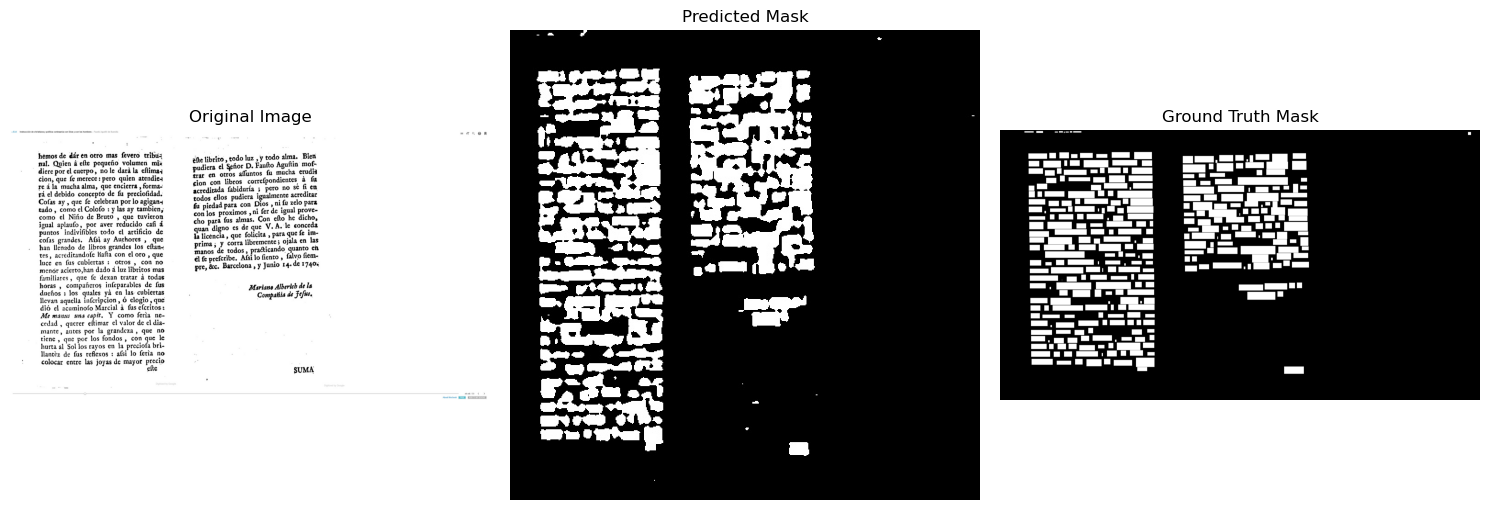

SSIM Score: 0.7542


In [97]:
original_image_path = "/home/aniketj/GSOC_TASK1/IMAGES/BuendiaInstruccion_page_5.jpg"
true_mask_path = "/home/aniketj/GSOC_TASK1/MASKS/BuendiaInstruccion_page_5.jpg"
pred_mask_path = "/home/aniketj/GSOC_TASK1/PREDICTED_MASKS/BuendiaInstruccion_page_5.jpg"
pred_mask = cv2.imread(pred_mask_path, cv2.IMREAD_GRAYSCALE)
true_mask = cv2.imread(true_mask_path, cv2.IMREAD_GRAYSCALE)
true_mask = cv2.resize(true_mask, (pred_mask.shape[1], pred_mask.shape[0]))

plot_layout_comparison(original_image_path,pred_mask_path,true_mask_path)
ssim_score = compute_ssim(pred_mask, true_mask)
print(f"SSIM Score: {ssim_score:.4f}")

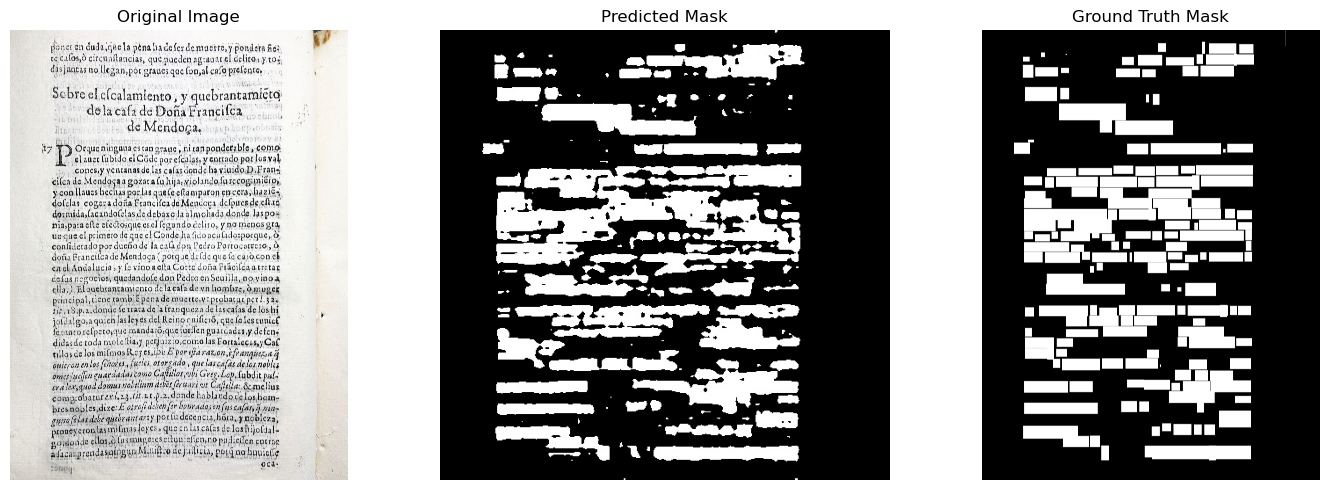

SSIM Score: 0.7471


In [98]:
original_image_path = "/home/aniketj/GSOC_TASK1/IMAGES/PORCONES_page_8.jpg"
true_mask_path = "/home/aniketj/GSOC_TASK1/MASKS/PORCONES_page_8.jpg"
pred_mask_path = "/home/aniketj/GSOC_TASK1/PREDICTED_MASKS/PORCONES_page_8.jpg"
pred_mask = cv2.imread(pred_mask_path, cv2.IMREAD_GRAYSCALE)
true_mask = cv2.imread(true_mask_path, cv2.IMREAD_GRAYSCALE)
pred_mask = cv2.resize(pred_mask, (true_mask.shape[1], true_mask.shape[0]))

plot_layout_comparison(original_image_path,pred_mask_path,true_mask_path)
ssim_score = compute_ssim(pred_mask, true_mask)
print(f"SSIM Score: {ssim_score:.4f}")

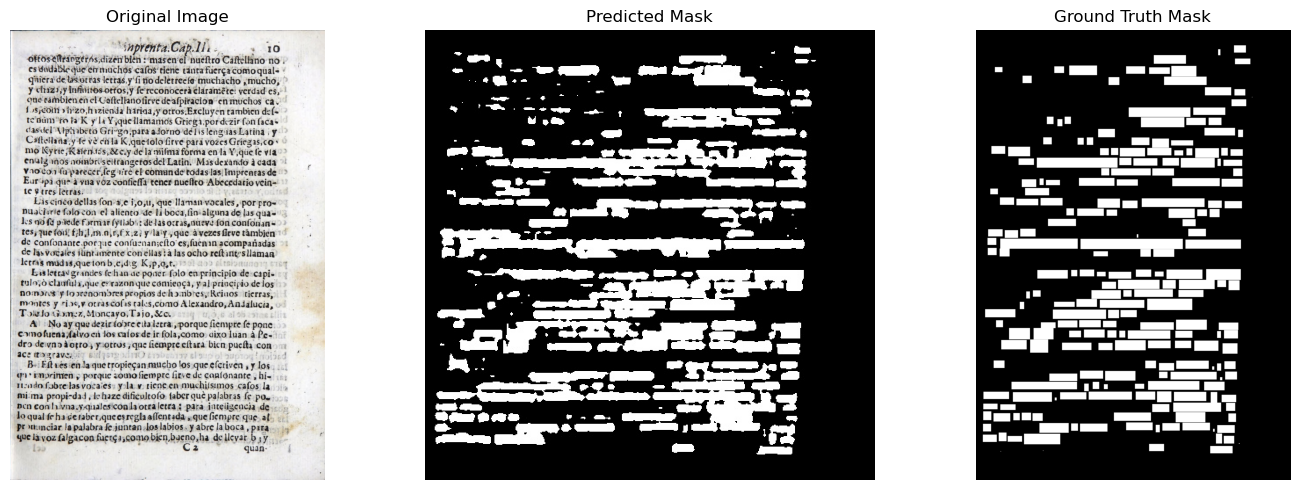

SSIM Score: 0.6622


In [99]:
original_image_path = "/home/aniketj/GSOC_TASK1/IMAGES/ParedesReglas generales_page_3.jpg"
true_mask_path = "/home/aniketj/GSOC_TASK1/MASKS/ParedesReglas generales_page_3.jpg"
pred_mask_path = "/home/aniketj/GSOC_TASK1/PREDICTED_MASKS/ParedesReglas generales_page_3.jpg"
pred_mask = cv2.imread(pred_mask_path, cv2.IMREAD_GRAYSCALE)
true_mask = cv2.imread(true_mask_path, cv2.IMREAD_GRAYSCALE)
pred_mask = cv2.resize(pred_mask, (true_mask.shape[1], true_mask.shape[0]))

plot_layout_comparison(original_image_path,pred_mask_path,true_mask_path)
ssim_score = compute_ssim(pred_mask, true_mask)
print(f"SSIM Score: {ssim_score:.4f}")


In [ ]:

ssim_scores = []


real_imgs = "/home/aniketj/GSOC_TASK1/MASKS"
generated_imgs = "/home/aniketj/GSOC_TASK1/PREDICTED_MASKS"


real_images = sorted(os.listdir(real_imgs))
generate_images = sorted(os.listdir(generated_imgs))


for real, generated in zip(real_images, generate_images):
    real_img_path = os.path.join(real_imgs, real)
    generated_img_path = os.path.join(generated_imgs, generated)
    
    pred_mask = cv2.imread(generated_img_path, cv2.IMREAD_GRAYSCALE)
    true_mask = cv2.imread(real_img_path, cv2.IMREAD_GRAYSCALE)
    pred_mask = cv2.resize(pred_mask, (true_mask.shape[1], true_mask.shape[0]))
    ssim_score = compute_ssim(pred_mask, true_mask)
    ssim_scores.append(ssim_score)


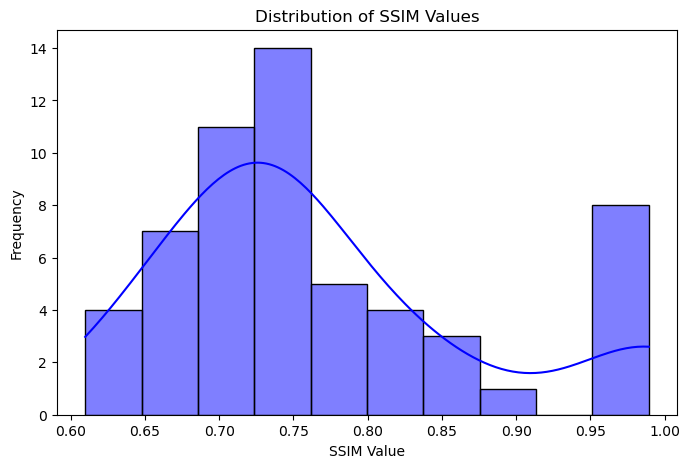

In [88]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(ssim_scores, bins=10, kde=True, color='blue')
plt.xlabel("SSIM Value")
plt.ylabel("Frequency")
plt.title("Distribution of SSIM Values")
plt.show()

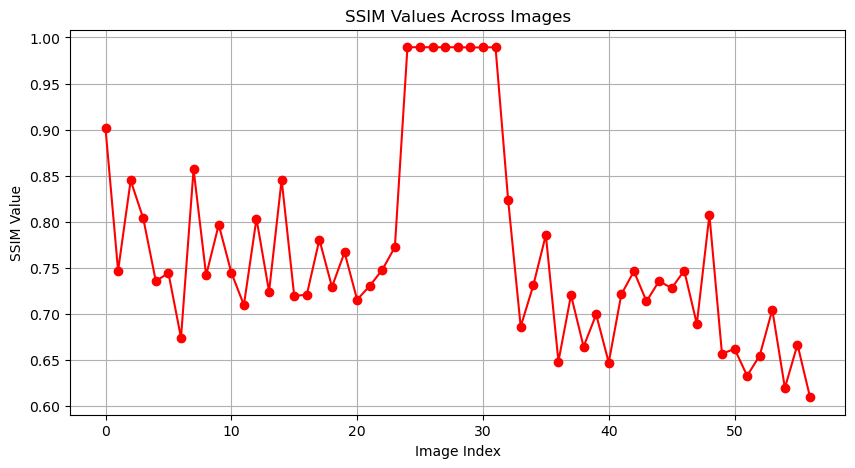

In [91]:
plt.figure(figsize=(10, 5))
plt.plot(ssim_scores, marker='o', linestyle='-', color='red')
plt.xlabel("Image Index")
plt.ylabel("SSIM Value")
plt.title("SSIM Values Across Images")
plt.grid()
plt.show()

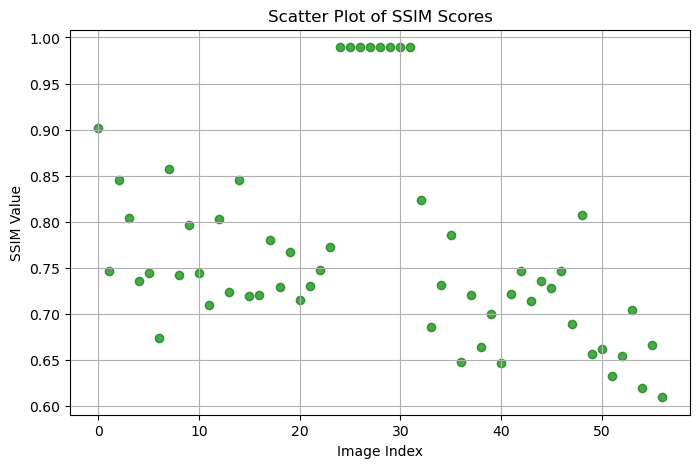

In [92]:
plt.figure(figsize=(8, 5))
plt.scatter(range(len(ssim_scores)), ssim_scores, color='green', alpha=0.7)
plt.xlabel("Image Index")
plt.ylabel("SSIM Value")
plt.title("Scatter Plot of SSIM Scores")
plt.grid()
plt.show()

In [ ]:
def load_image(image_path):
    img = cv2.imread(image_path)  
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    img = cv2.resize(img, (256, 256))  
    img = np.transpose(img, (2, 0, 1)) / 255.0 * 2 - 1  
    img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  
    return img

In [ ]:
def calculate_ssim(img1_path, img2_path):
    img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

    if img1 is None:
        raise FileNotFoundError(f"Could not load image: {img1_path}")
    if img2 is None:
        raise FileNotFoundError(f"Could not load image: {img2_path}")

    
    if img1.shape != img2.shape:
        img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

    score, _ = ssim(img1, img2, full=True)
    return score

In [ ]:

ssim_scores = []


real_imgs = "/home/aniketj/GSOC_TASK1/MASKS/"
generated_imgs = "/home/aniketj/GSOC_TASK1/PREDICTED_MASKS/"


real_images = sorted(os.listdir(real_imgs))
generate_images = sorted(os.listdir(generated_imgs))


for real, generated in zip(real_images, generate_images):
    real_img_path = os.path.join(real_imgs, real)
    generated_img_path = os.path.join(generated_imgs, generated)
    
    
    real_image = load_image(real_img_path)  
    fake_image = load_image(generated_img_path)  

    ssim_score = calculate_ssim(generated_img_path , real_img_path)
    ssim_scores.append(ssim_score)

In [9]:
import statistics
mean = statistics.mean(ssim_scores)
median = statistics.median(ssim_scores)
minimum = min(ssim_scores)
maximum = max(ssim_scores)
print(f"SSIM : Average = {mean:.6f}, Median = {median:.6f}, Min = {minimum:.6f}, Max = {maximum:.6f}")

SSIM : Average = 0.838045, Median = 0.857945, Min = 0.677889, Max = 0.988759


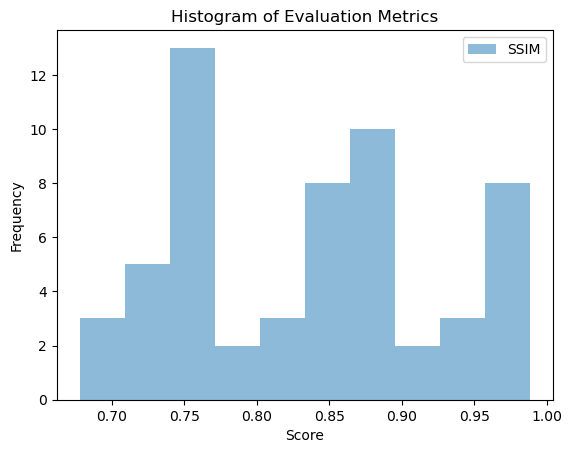

In [10]:
plt.hist(ssim_scores, bins=10, alpha=0.5, label='SSIM')
plt.title('Histogram of Evaluation Metrics')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

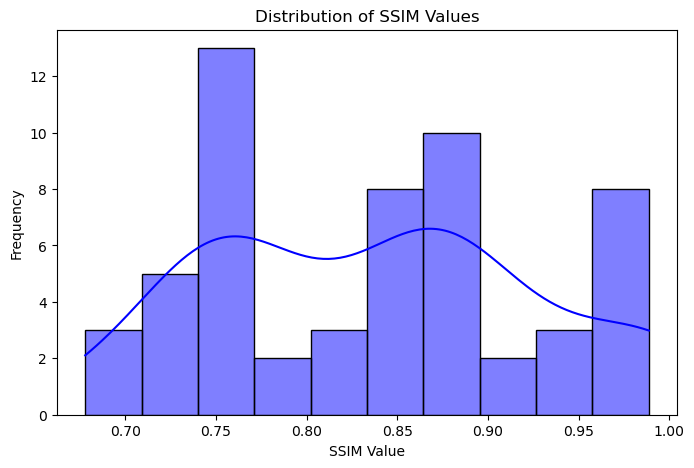

In [11]:
plt.figure(figsize=(8, 5))
sns.histplot(ssim_scores, bins=10, kde=True, color='blue')
plt.xlabel("SSIM Value")
plt.ylabel("Frequency")
plt.title("Distribution of SSIM Values")
plt.show()

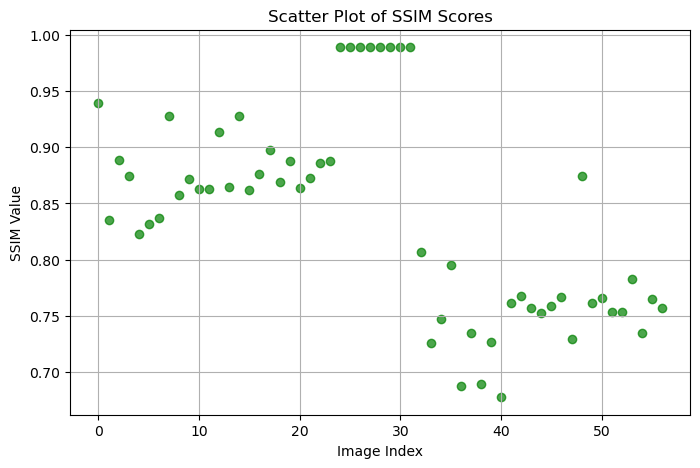

In [12]:
plt.figure(figsize=(8, 5))
plt.scatter(range(len(ssim_scores)), ssim_scores, color='green', alpha=0.7)
plt.xlabel("Image Index")
plt.ylabel("SSIM Value")
plt.title("Scatter Plot of SSIM Scores")
plt.grid()
plt.show()